In [50]:
#installations needed if not installed already
!pip install pandas spacy numpy gym tensorflow matplotlib urllib3

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
#import statements
import json
import pandas as pd
import spacy
import numpy as np
import gym
import tensorflow as tf
import copy
import random
import pylab
import os
import gzip
from urllib.request import urlopen
from collections import deque
from keras import layers, models
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense

In [3]:
!wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/AMAZON_FASHION.json.gz

--2023-10-03 15:10:13--  https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/AMAZON_FASHION.json.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93185167 (89M) [application/x-gzip]
Saving to: ‘AMAZON_FASHION.json.gz’

AMAZON_FASHION.json 100%[===================>]  88.87M  40.9MB/s    in 2.2s    

2023-10-03 15:10:16 (40.9 MB/s) - ‘AMAZON_FASHION.json.gz’ saved [93185167/93185167]



In [53]:
###  Load JSON data

data = []
with gzip.open('AMAZON_FASHION.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))

# total length of list, this number equals total number of products
print(len(data))

# first row of the list
print(data[0])

883636
{'overall': 5.0, 'verified': True, 'reviewTime': '10 20, 2014', 'reviewerID': 'A1D4G1SNUZWQOT', 'asin': '7106116521', 'reviewerName': 'Tracy', 'reviewText': 'Exactly what I needed.', 'summary': 'perfect replacements!!', 'unixReviewTime': 1413763200}


In [54]:
#load spacy for nlp related noun extraction, stopword removal and others
nlp = spacy.load('en_core_web_sm')


# Create a DataFrame for easier data manipulation
df = pd.DataFrame(data)

df = df[['overall','verified','reviewerID','asin','style','reviewerName','reviewText', 'summary','reviewTime']]

# Filter verified reviews with non-null overall ratings
filtered_df = df[(df['verified'] == True) & (~df['overall'].isnull())]

print(filtered_df.head(10))




#Create FashionProduct class for a product representation from reviews
class FashionProduct() : pass
class Reviewer() : pass
# extract nouns from review text
def extract_nouns(doc):
    return " ".join([token.text for token in doc if token.pos_ == "NOUN" or token.pos_ == "PROPN"])

    overall  verified      reviewerID        asin                 style  \
0       5.0      True  A1D4G1SNUZWQOT  7106116521                   NaN   
1       2.0      True  A3DDWDH9PX2YX2  7106116521                   NaN   
3       2.0      True  A2UH2QQ275NV45  7106116521                   NaN   
5       5.0      True  A29HLOUW0NS0EH  7106116521                   NaN   
6       4.0      True   A7QS961ROI6E0  7106116521                   NaN   
7       3.0      True  A1BB77SEBQT8VX  B00007GDFV  {'Color:': ' Black'}   
8       3.0      True   AHWOW7D1ABO9C  B00007GDFV  {'Color:': ' Black'}   
9       3.0      True   AKS3GULZE0HFC  B00007GDFV  {'Color:': ' Black'}   
10      4.0      True   A38NS6NF6WPXS  B00007GDFV  {'Color:': ' Black'}   
11      2.0      True  A1KOKO3HTSAI1H  B00007GDFV  {'Color:': ' Black'}   

          reviewerName                                         reviewText  \
0                Tracy                             Exactly what I needed.   
1            Sonja L

In [7]:
# group reviews by reviewers
reviewers= {}
class Reviewer() : pass
grouped_df_reviwerId = filtered_df.groupby('reviewerID')
for reviewerId, group in grouped_df_reviwerId:
    products= group[group['asin'].notna()]['asin'].unique()
    if len(products)>10:
        reviewer= Reviewer()
        reviewer.reviewerId = reviewerId
        reviewer.products = products
        reviewer.product_cnt = len(products)
        reviewers[reviewerId]= reviewer
print(len(reviewers))


110


In [8]:
reviewer_values= list(reviewers.values())
print (len([reviewer for reviewer in reviewer_values if reviewer.product_cnt>=20]))
print (len([reviewer for reviewer in reviewer_values if reviewer.product_cnt>=15]))



12
35


### Hence we do not have decent no. of users who have purchases more than 15 or 20 products, so we will go with reviewers who have purchased more than 10 products only. We will filter out reviewers with less than or equal to 10 products and go with recommending only two products per product for better accuracy in prediction.

In [9]:
print(len(filtered_df))
#remove other reviewer's data
filtered_df = filtered_df[(filtered_df['reviewerID'].isin([reviewer.reviewerId for reviewer in reviewer_values]) )]
print(len(filtered_df))

828699
1622


In [10]:
print(filtered_df.head(10))


       overall  verified      reviewerID        asin  \
3368       5.0      True   AAC2BU2V9X95K  B000EE1NNA   
12731      5.0      True  A1H2WJSALF3E9U  B000KPIHQ4   
16417      5.0      True  A2IQT5AFFXA1OM  B000NBIMG0   
17435      5.0      True  A2T2ZJ8NQ7PP5J  B000NGJ41W   
26234      5.0      True  A1H2WJSALF3E9U  B000V0IBDM   
33572      5.0      True  A3BX45SC5SG8BM  B0014F8TIU   
40825      5.0      True  A3BX45SC5SG8BM  B0014F8TIU   
45088      3.0      True   AC882JEHSEWW6  B001AV1OVC   
45136      3.0      True   AC882JEHSEWW6  B001AV3SS4   
48895      5.0      True  A3VGHF7VNFBMCQ  B001IKJOLW   

                                                   style   reviewerName  \
3368          {'Size:': ' Large', 'Color:': ' Blue/Red'}             me   
12731  {'Size Name:': ' Men's 12-13.5, Women's 14-15....         Papa T   
16417  {'Size:': ' 39/40 BR/9-10 M US', 'Color:': ' N...     Tina Diane   
17435                                    {'Size:': ' 9'}        Ruth U.   
26234   

### So we have reduced dataset size form 828699 rows to 1622 rows

In [11]:
# Group reviews by product ASIN
filtered_df['reviewTime']=pd.to_datetime(filtered_df['reviewTime'])
filtered_df.sort_values('reviewTime')
grouped_df = filtered_df.groupby(['asin', 'reviewerID', 'reviewTime'], sort=False)
print (len(grouped_df))

1620


<ipython-input-11-44afb871e158>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['reviewTime']=pd.to_datetime(filtered_df['reviewTime'])


In [12]:
# Initialize a dictionary to store product features as states
states= {}
products= {}

# Iterate over each product
for (product_asin, reviewerId, reviewTime), group in grouped_df:
    if (product_asin, reviewerId) in states: continue
    product = FashionProduct()
    product.product_asin = product_asin
    product.reviewerId = reviewerId
    product.time = reviewTime
    if product_asin not in products:
        products[product_asin] = product
        p= products[product_asin]
        p.reviewers = set()
        p.sizes = set()
        p.colors = set()
        p.reviews = set()
        p.rating =[]

    product.reviewers = products[product_asin].reviewers



    # extract size and color metadata from style column
    styles=  group[group['style'].notna()]['style']
    sizes = styles.apply(lambda x: x.get("Size:", "") if "Size:" in x else x.get("Size Name:", "")).unique().tolist()
    colors = styles.apply(lambda x: x.get("Color:", "")).unique().tolist()

    products[product_asin].sizes.update(sizes)
    products[product_asin].colors.update(colors)

    #extract other noun metadata from review text
    reviews = group[group['reviewText'].notna()]['reviewText']
    reviews = " ".join(reviews.apply(lambda x: " ".join([extract_nouns(chunk) for chunk in nlp(x).noun_chunks]).strip()).unique())
    products[product_asin].reviews.update(reviews)
    #using rms instead of average for review ratings to give slightly higher weightage to good reviews
    ratings = group[group['overall']>0]['overall'].tolist()
    products[product_asin].rating.extend(ratings)
    product.ratings = np.sqrt(np.mean( [r**2 for r in products[product_asin].rating]))

    sizes = " ".join(products[product_asin].sizes)
    colors = " ".join(products[product_asin].colors)
    reviews = " ".join(products[product_asin].reviews)
    product.metadata= " ".join((reviews+" "+sizes+" "+colors).split())

    # add past product and reviewer's product metadata
    # we will take metatdata of last 2 reviewer only as large metadata causes memory issues
    for reviewer in list(product.reviewers)[-2:]:
        state = states[(product_asin, reviewer)]
        product.metadata += " "+state.metadata

    # keep past reviewer list
    products[product_asin].reviewers.add(reviewerId)

    states[(product_asin, reviewerId)] = product

states_list= list(states.values())


In [13]:
states_list.sort(key=lambda x: x.time)
print (len(states_list))
users={}

1618


In [14]:
for state in states_list:
    if state.reviewerId not in users:
        users[state.reviewerId] = Reviewer()
        users[state.reviewerId].products= set()
    for prod1 in list(users[state.reviewerId].products)[-2:]:
        state1 = states[(prod1, state.reviewerId)]
        state.metadata += state1.metadata
    # keep past products list
    users[state.reviewerId].products.add(state.product_asin)


In [15]:
#remove states with empty metadata
states_list= [s for s in states_list if s.metadata.strip() != '']
print(len(states_list))

1584


In [16]:
# Create Product Recommendation env
class RecommendationEnv(gym.Env):
    def __init__(self, states, states_dict, iterations = 10):
        self.states = states
        self.state = self.states[0]
        self.states_dict = states_dict
        self.iterations = iterations
        self.index = 0
        state.action = 0


    def step(self, actions):
        # Implement the transition logic based on the action
        reward= 0
        done= False
        reviewerId= self.state.reviewerId
        future_asins= [p for p in reviewers[reviewerId].products if self.states_dict[(p,reviewerId)].time>self.state.time]
        matched_recommendations = False
        #predicted recommendations
        for i in actions:
          if self.states[i].product_asin in future_asins:
            self.action = i
            matched_recommendations = True
            break;


        if matched_recommendations:
            #Higher reward as they are bought products for the user in future
            reward = 1
        else:
            self.action = actions[0]


        self.index += 1
        self.state = self.states[self.index]
        print(f"iteration :{self.index}")
        if (self.iterations == self.index): done = True

        return self.state, reward, done, {}




    def reset(self, iterations = 10):
        # Reset the state to the initial position
        self.state = self.states[0]
        self.iterations = iterations
        self.index = 0
        return self.state

# Create the custom environment
env = RecommendationEnv(states_list, states, 10)

In [14]:
# Implementation of DQN algorithm
class DQNAgent:
    def __init__(self, state_size, action_size, states):
        self.states = states
        self.state_size = state_size
        self.action_size = action_size

        # These are hyper parameters for the DQN
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.batch_size = 64
        self.train_start = 1000
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()
        self.target_model = self.build_model()

        # initialize target model
        self.update_target_model()

    # approximate Q function using Neural Network
    # state is input and Q Value of each action is output of network
    def build_model(self):
        #Using RNN as it is recommended for text classification
        # Using the TextVectorization layer to normalize, split, and map strings
        # to integers.
        encoder = tf.keras.layers.TextVectorization(max_tokens=10000)
        metadatas = [product.metadata for product in self.states]
        ratings = [product.ratings for product in self.states]
        encoder.adapt(metadatas)

        model = tf.keras.Sequential([
            encoder,
            layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
            layers.Bidirectional(layers.LSTM(64,  return_sequences=True)),
            layers.Bidirectional(tf.keras.layers.LSTM(32)),
            layers.Dense(64, activation='relu')
        ])
        # Create an input layer for ratings
        ratings_input = tf.keras.layers.Input(shape=(1,), name='ratings_input')

        # Concatenate the output of the previous layers with ratings
        concatenated = layers.concatenate([model.output, ratings_input])

        # Add additional layers for your desired architecture
        dense_layer = layers.Dense(64, activation='relu')(concatenated)
         # One Q-value per action
        output_layer = layers.Dense(len(self.states), activation='linear')(dense_layer)

        # Create the final model with both metadata and ratings as inputs
        model = tf.keras.Model(inputs=[model.input, ratings_input], outputs=output_layer)
        # Summary of the model
        model.summary()

        # Compile the model
        model.compile(loss='mse',
                      optimizer=Adam(learning_rate=self.learning_rate))
        return model

    # after some time interval update the target model to be same with model
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # get recommendations from model using epsilon-greedy policy
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.sample(range(self.action_size),10)
        else:
            q_value = self.model.predict([np.array([state.metadata]), np.array([state.ratings])])
            return np.argpartition(q_value[0],-10)[-10:]

    # save sample <s,a,r,s'> to the replay memory
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    # pick samples randomly from replay memory (with batch_size)
    def train_model(self):
        if len(self.memory) < self.train_start:
            return
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size)

        update_input_metadata =[]
        update_input_ratings =[]
        update_target_metadata = []
        update_target_ratings = []
        action, reward, done = [], [], []

        for i in range(self.batch_size):
            update_input_metadata.append(np.array(mini_batch[i][0].metadata))
            update_input_ratings.append(np.array(mini_batch[i][0].ratings))
            action.append(mini_batch[i][1])
            reward.append(mini_batch[i][2])
            update_target_metadata.append(np.array(mini_batch[i][3].metadata))
            update_target_ratings.append(np.array(mini_batch[i][3].ratings))
            done.append(mini_batch[i][4])

        target = self.model.predict([np.transpose(update_input_metadata),np.transpose(update_input_ratings)])
        target_val = self.target_model.predict([np.transpose(update_target_metadata),np.transpose(update_target_ratings)])

        for i in range(self.batch_size):
            # Q Learning: get maximum Q value at s' from target model
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                target[i][action[i]] = reward[i] + self.discount_factor * ( np.amax(target_val[i]))

        # and do the model fit!
        self.model.fit([np.transpose(update_input_metadata),np.transpose(update_input_ratings)], target, batch_size=self.batch_size,
                       epochs=1, verbose=1)


In [15]:
state_size = len(env.states)
# Every other product can be a recommendation
action_size = state_size
agent = DQNAgent(state_size, action_size, env.states)
scores, episodes = [], []
EPISODES = 25







Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_vectorization_input (  [(None,)]                    0         []                            
 InputLayer)                                                                                      
                                                                                                  
 text_vectorization (TextVe  (None, None)                 0         ['text_vectorization_input[0][
 ctorization)                                                       0]']                          
                                                                                                  
 embedding (Embedding)       (None, None, 64)             35264     ['text_vectorization[0][0]']  
                                                                                              

iteration :1
iteration :2
iteration :3
iteration :4
iteration :5
iteration :6
iteration :7
iteration :8
iteration :9
iteration :10
iteration :11
iteration :12
iteration :13
iteration :14
iteration :15
iteration :16
iteration :17
iteration :18
iteration :19
iteration :20
iteration :21
iteration :22
iteration :23
iteration :24
iteration :25
iteration :26
iteration :27
iteration :28
iteration :29
iteration :30
iteration :31
iteration :32
iteration :33
iteration :34
iteration :35
iteration :36
iteration :37
iteration :38
iteration :39
1/1 [==============================] - 7s 7s/step
iteration :40
iteration :41
iteration :42
iteration :43
iteration :44
iteration :45
iteration :46
iteration :47
iteration :48
iteration :49
iteration :50
episode: 0   score: 4   memory length: 50   epsilon: 0.9512056281970315
iteration :1
iteration :2
iteration :3
iteration :4
iteration :5
iteration :6
iteration :7
1/1 [==============================] - 0s 74ms/step
iteration :8
iteration :9
iteration :10
iter

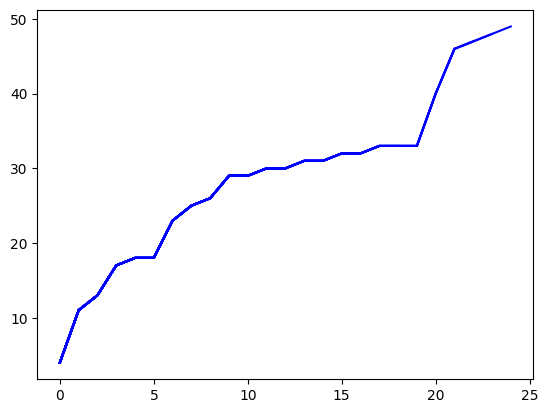

In [16]:
#cache already rewarded recommendations (optimization done based upon context and to improve the performance to a large extent)
next_states = {}
done_value = {}
action_value = {}
for e in range(EPISODES):
    done = False
    score = 0
    state = env.reset(50)

    while not done:
        if (state.product_asin, state.reviewerId) in next_states:
          next_state = next_states[(state.product_asin, state.reviewerId)]
          reward = 1
          done = done_value[(state.product_asin, state.reviewerId)]
          action = action_value[(state.product_asin, state.reviewerId)]
          env.index += 1
        else:
          # get action for the current state and go one step in environment
          actions = agent.get_action(state)
          next_state, reward, done, info = env.step(actions)
          action = env.action
          if (reward == 1):
            next_states[(state.product_asin, state.reviewerId)]= next_state
            done_value[(state.product_asin, state.reviewerId)] = done
            action_value[(state.product_asin, state.reviewerId)] = env.action

        # save the sample <s, a, r, s'> to the replay memory
        agent.append_sample(state, action, reward, next_state, done)
        # every time step do the training
        agent.train_model()
        score += reward
        state = next_state

        if done:
            # every episode update the target model to be same with model
            agent.update_target_model()


            scores.append(score)
            episodes.append(e)
            pylab.plot(episodes, scores, 'b')
            print("episode:", e, "  score:", score, "  memory length:",
                  len(agent.memory), "  epsilon:", agent.epsilon)
    if (score > 48): break



In [17]:

agent.model.save('Reco_DQN.keras')

In [45]:

#Deep REINFORCE Implementation
class REINFORCEAgent:
    def __init__(self, state_size, action_size, states):
        self.states = states
        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # These are hyper parameters for the Policy Gradient
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.hidden1, self.hidden2 = 24, 24

        # create model for policy network
        self.model = self.build_model()

        # lists for the states, actions and rewards
        self.states, self.actions, self.rewards = [], [], []

    # approximate policy using Neural Network
    # state is input and probability of each action is output of network
    def build_model(self):
        #Using RNN as it is recommended for text classification
        # Using the TextVectorization layer to normalize, split, and map strings
        # to integers.
        encoder = tf.keras.layers.TextVectorization(max_tokens=10000)
        metadatas = [product.metadata for product in self.states]
        ratings = [product.ratings for product in self.states]
        encoder.adapt(metadatas)

        model = tf.keras.Sequential([
            encoder,
            layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
            layers.Bidirectional(layers.LSTM(64,  return_sequences=True)),
            layers.Bidirectional(tf.keras.layers.LSTM(32)),
            layers.Dense(64, activation='relu')
        ])
        # Create an input layer for ratings
        ratings_input = tf.keras.layers.Input(shape=(1,), name='ratings_input')

        # Concatenate the output of the previous layers with ratings
        concatenated = layers.concatenate([model.output, ratings_input])

        # Add additional layers for your desired architecture
        dense_layer = layers.Dense(64, activation='relu')(concatenated)
         # One Q-value per action
        output_layer = layers.Dense(len(self.states), activation='softmax')(dense_layer)
        # Create the final model with both metadata and ratings as inputs
        model = tf.keras.Model(inputs=[model.input, ratings_input], outputs=output_layer)
        # Summary of the model
        model.summary()

        # Compile the model
        model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=self.learning_rate))
        return model

    # using the output of policy network, pick action stochastically
    def get_actions(self, state):
        policy = self.model.predict([np.array([state.metadata]), np.array([state.ratings])], batch_size=1).flatten()
        return np.random.choice(self.action_size, 10, p=policy)

    # In Policy Gradient, Q function is not available.
    # Instead agent uses sample returns for evaluating policy
    def discount_rewards(self, rewards):
        discounted_rewards = np.zeros_like(rewards, dtype=float)
        running_add = 0
        for t in reversed(range(0, len(rewards))):
            running_add = running_add * self.discount_factor + rewards[t]
            discounted_rewards[t] = running_add
        return discounted_rewards

    # save <s, a ,r> of each step
    def append_sample(self, state, action, reward):
        self.states.append(state)
        self.rewards.append(reward)
        self.actions.append(action)

    # update policy network every episode
    def train_model(self):
        episode_length = len(self.states)

        discounted_rewards = self.discount_rewards(self.rewards)
        discounted_rewards -= np.mean(discounted_rewards)
        discounted_rewards /= np.std(discounted_rewards)

        update_input_metadata = []
        update_input_ratings = []
        advantages = np.zeros((episode_length, self.action_size))

        for i in range(episode_length):
            update_input_metadata.append(self.states[i].metadata)
            update_input_ratings.append(self.states[i].ratings)
            advantages[i][self.actions[i]] = discounted_rewards[i]

        self.model.fit([np.transpose(update_input_metadata),np.transpose(update_input_ratings)], advantages, epochs=1, verbose=0)
        self.states, self.actions, self.rewards = [], [], []



In [48]:
# Create the custom environment
env = RecommendationEnv(states_list, states, 10)
state_size = len(env.states)
# Every other product can be a recommendation
action_size = state_size
scores, episodes = [], []
EPISODES = 25
# make REINFORCE agent
agent = REINFORCEAgent(state_size, action_size, env.states)

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_vectorization_10_inpu  [(None,)]                    0         []                            
 t (InputLayer)                                                                                   
                                                                                                  
 text_vectorization_10 (Tex  (None, None)                 0         ['text_vectorization_10_input[
 tVectorization)                                                    0][0]']                       
                                                                                                  
 embedding_10 (Embedding)    (None, None, 64)             35520     ['text_vectorization_10[0][0]'
                                                                    ]                      

1/1 [==============================] - 5s 5s/step
iteration :1
1/1 [==============================] - 0s 32ms/step
iteration :2
1/1 [==============================] - 0s 43ms/step
iteration :3
1/1 [==============================] - 0s 54ms/step
iteration :4
1/1 [==============================] - 0s 83ms/step
iteration :5
1/1 [==============================] - 0s 62ms/step
iteration :6
1/1 [==============================] - 0s 67ms/step
iteration :7
1/1 [==============================] - 0s 74ms/step
iteration :8
1/1 [==============================] - 0s 64ms/step
iteration :9
1/1 [==============================] - 0s 96ms/step
iteration :10
1/1 [==============================] - 0s 100ms/step
iteration :11
1/1 [==============================] - 0s 99ms/step
iteration :12
1/1 [==============================] - 0s 31ms/step
iteration :13
1/1 [==============================] - 0s 136ms/step
iteration :14
1/1 [==============================] - 0s 27ms/step
iteration :15
1/1 [==============

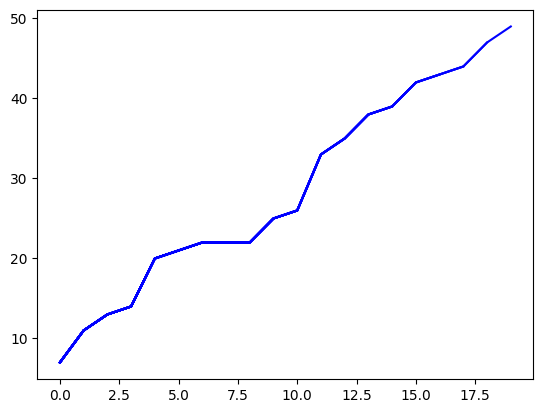

In [49]:
# run algorithm
scores, episodes = [], []
#cache already rewarded recommendations
next_states = {}
done_value = {}
action_value = {}
for e in range(EPISODES):
  done = False
  score = 0
  state = env.reset(50)

  while not done:
      if (state.product_asin, state.reviewerId) in next_states:
          next_state = next_states[(state.product_asin, state.reviewerId)]
          reward = 1
          done = done_value[(state.product_asin, state.reviewerId)]
          action = action_value[(state.product_asin, state.reviewerId)]
          env.index += 1
      else:
          # get action for the current state and go one step in environment
          actions = agent.get_actions(state)
          next_state, reward, done, info = env.step(actions)
          action= env.action
          if (reward == 1):
            next_states[(state.product_asin, state.reviewerId)]= next_state
            done_value[(state.product_asin, state.reviewerId)] = done
            action_value[(state.product_asin, state.reviewerId)] = env.action
      # save the sample <s, a, r> to the memory
      agent.append_sample(state, action, reward)

      score += reward
      state = next_state

      if done:
          # every episode, agent learns from sample returns
          agent.train_model()
          scores.append(score)
          episodes.append(e)
          pylab.plot(episodes, scores, 'b')
          print("episode:", e, "  score:", score)

  if (score > 48): break


Your formal method to compare the results of deliverables 4 and 5. This will be evaluated
for 2 Marks. Choice of appropriate measures, and your comments
on the result counts.


Both DQN and Deep REINFORCED performed well and converged in very less episode by adding the optimization code which I added, however Deep REINFORCE performed better, it converged very fast within a minute and 19 episodes with 49/50 correct recommendation. DQN converged in 3 minutes and 25 episodes with 49/50 scores. Both recommended correct next buys for 49 products out of 50 products which we tested with a limit of 25 episodes.